# Cluster

## Objectives

* Fit and evaluate a cluster model to group similar data
* Understand the profile for each cluster


## Inputs

* outputs/datasets/collection/TelcoCustomerChurn.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in their respective notebooks.

## Outputs

* Cluster Pipeline
* Train Set
* Most important features to define a cluster plot
* Clusters Profile Description
* Cluster Silhouette


The objective of this notebook is to: fit a Cluster ML pipeline
that groups similar users, and understands each cluster profile.
We will also analyze how Churn levels are distributed across the Clusters.

It should be noted that we are now working with unsupervised learning
as opposed to previously when we were working with supervised learning.
Unsupervised Learning is slightly different due to one aspect:
there is no target variable. The algorithm is left on its own to find patterns in the data.

---

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\kathr\\Nextcloud\\Dokumente\\Karriere\\Projekte\\vscode-projects\\PP5\\LoanGuard\\jupyter_notebooks'

We want to make the parent of the parent of current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\kathr\\Nextcloud\\Dokumente\\Karriere\\Projekte\\vscode-projects\\PP5\\LoanGuard'

---

# Load Data

Drop “customerID”, “Total Charges”, “Tenure” since they don’t fit a prospect's context.
We'll also drop “Churn”, since we will analyze how Churn levels are distributed

In [5]:
import numpy as np
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/LoanDefaultData.csv")

print(df.shape)
df.head(3)

(25534, 18)


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,QPIE1NQFSY,57,51244,180500,627,94,2,15.22,24,0.50,Master's,Full-time,Married,Yes,Yes,Auto,No,0
1,KKHO8S35ZJ,65,148892,194233,603,3,1,18.98,36,0.67,Bachelor's,Part-time,Married,No,No,Education,No,0
2,8SBBOMTDSC,61,55177,163218,422,15,4,6.38,60,0.43,Bachelor's,Full-time,Single,No,No,Home,Yes,0


# Cluster Pipeline with all data

##  ML Cluster Pipeline

In [6]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection, DropFeatures

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# PCA
from sklearn.decomposition import PCA

# ML algorithm
from sklearn.cluster import KMeans


def PipelineCluster():
    pipeline_base = Pipeline([
        ("DropFeatures", DropFeatures(features_to_drop=["LoanID", "Default"])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=["EmploymentType", "MaritalStatus", "LoanPurpose", 
                                                                "HasMortgage", "HasDependents", "HasCoSigner", "Education"])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman",
                                                              threshold=0.5, selection_method="variance")),

        ("scaler", StandardScaler()),

        # We use PCA since we want to provide only relevant information to the model.
        # We’ll initially set an arbitrary number of PCA components
        # and the number of clusters for the model since we will calculate them in an upcoming section.
        ("PCA", PCA(n_components=50, random_state=0)),
        # KMeans  is generally seen as a good starting point when learning about cluster analysis
        ("model", KMeans(n_clusters=50, random_state=0)),


    ])
    return pipeline_base


## Principal Component Analysis (PCA)

let’s find the most suitable `n_components`,
then we will update the value on the Cluster Pipeline.

In [9]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.steps[:-2]

[('DropFeatures', DropFeatures(features_to_drop=['LoanID', 'Default'])),
 ('OrdinalCategoricalEncoder',
  OrdinalEncoder(encoding_method='arbitrary',
                 variables=['EmploymentType', 'MaritalStatus', 'LoanPurpose',
                            'HasMortgage', 'HasDependents', 'HasCoSigner',
                            'Education'])),
 ('SmartCorrelatedSelection',
  SmartCorrelatedSelection(method='spearman', selection_method='variance',
                           threshold=0.5)),
 ('scaler', StandardScaler())]

In [10]:
# we transform the data using the cluster pipeline
# until we reach the feature scaling step since the PCA needs a scaled dataset.
pipeline_cluster = PipelineCluster()
pipeline_pca = Pipeline(pipeline_cluster.steps[:-2])
df_pca = pipeline_pca.fit_transform(df)

print(df_pca.shape,'\n', type(df_pca))


(25534, 16) 
 <class 'numpy.ndarray'>


After cleaning already only 12 columns left (from 17)

Apply PCA separately to the scaled data

* The 16 components explain 100.0% of the data 



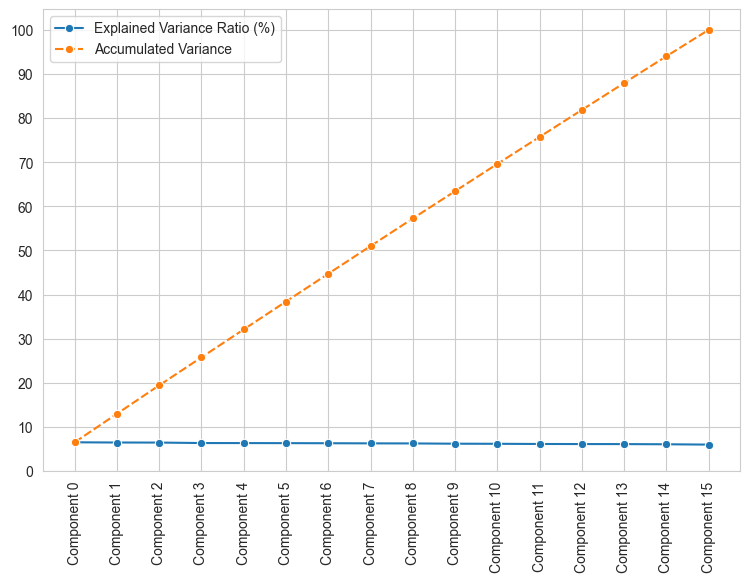

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

n_components = 16 # initially set to number of columns


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)


* The 6 components explain 77.32% of the data 



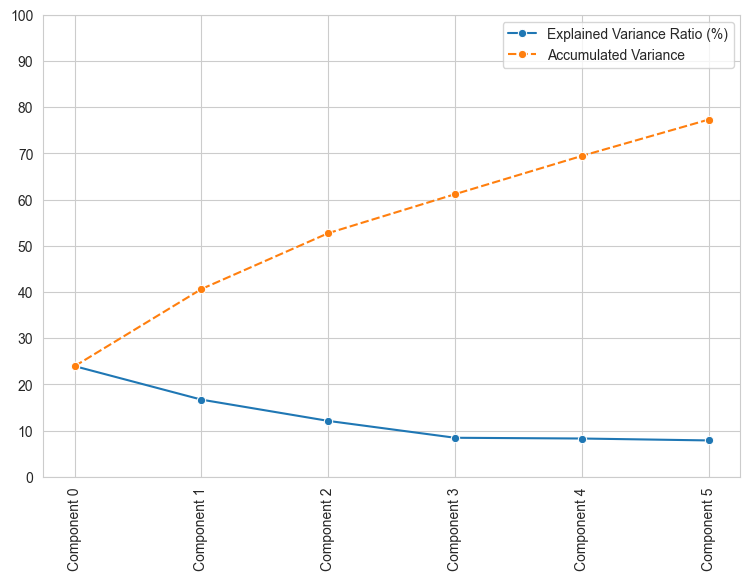

In [ ]:
# reduce n_componentns to 6
# rule of thumb: around 80% of variance should be explained, here 6 components explain 77 %
# we also dont want too many components, and 6 is half of 12, so its ok
pca_components_analysis(df_pca=df_pca,n_components=6)

In [12]:
# update n_components to 6
def PipelineCluster():
    pipeline_base = Pipeline([
        ("DropFeatures", DropFeatures(features_to_drop=["LoanID", "Default"])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=["EmploymentType", "MaritalStatus", "LoanPurpose", 
                                                                "HasMortgage", "HasDependents", "HasCoSigner", "Education"])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman",
                                                              threshold=0.6, selection_method="variance")),

        ("scaler", StandardScaler()),

        # we update n_components to 6
        ("PCA", PCA(n_components=9, random_state=0)),

        ("model", KMeans(n_clusters=50, random_state=0)),


    ])
    return pipeline_base


PipelineCluster()


Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['LoanID', 'Default'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['EmploymentType', 'MaritalStatus',
                                           'LoanPurpose', 'HasMortgage',
                                           'HasDependents', 'HasCoSigner',
                                           'Education'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=9, random_state=0)),
                ('model', KMeans(n_clusters=50, random_state=0))])

## Elbow Method and Silhouette Score

In [13]:
# transform data up to PCA step
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df)

print(df_analysis.shape,'\n', type(df_analysis))

(25534, 9) 
 <class 'numpy.ndarray'>


We run k-means clustering for a range of values for “number of clusters” and then plot their distortion scores -> elbow

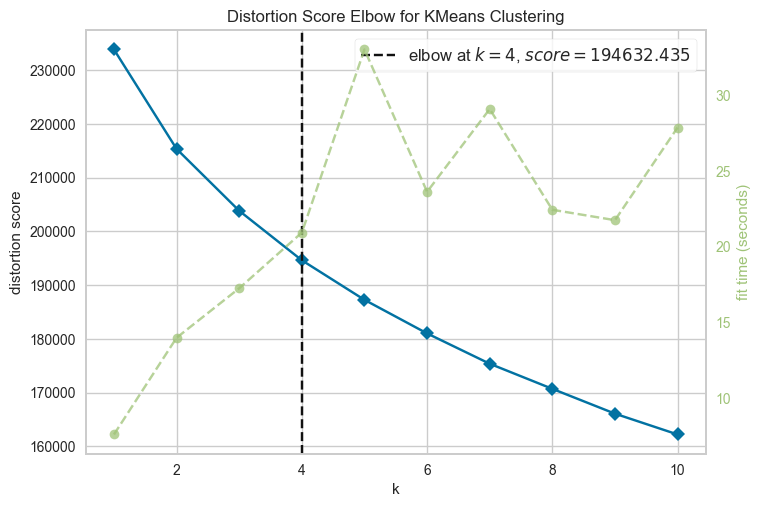

In [14]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,11)) # 11 is not inclusive, it will plot until 10
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()

suggests k=4. 

also we want to  evaluate a range around that
number where there is a sharp drop, here 2-5 (omitted
1 here because we’re not interested in having a single cluster at the end of the analysis.) -> for silhouette analysis we want to look at different values of k to determine the best as well

=== Average Silhouette Score for different number of clusters ===


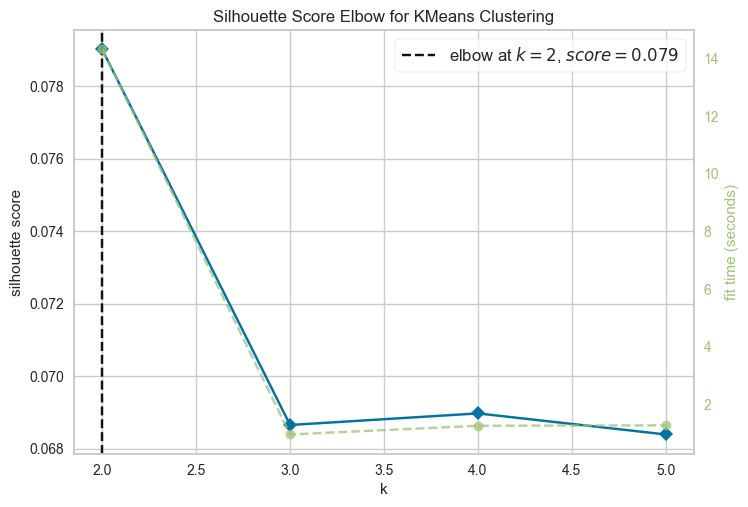



=== Silhouette plot for 2 Clusters ===


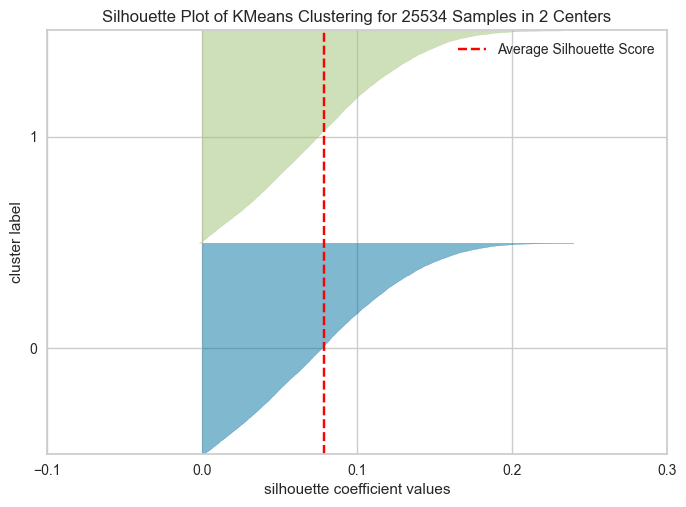



=== Silhouette plot for 3 Clusters ===


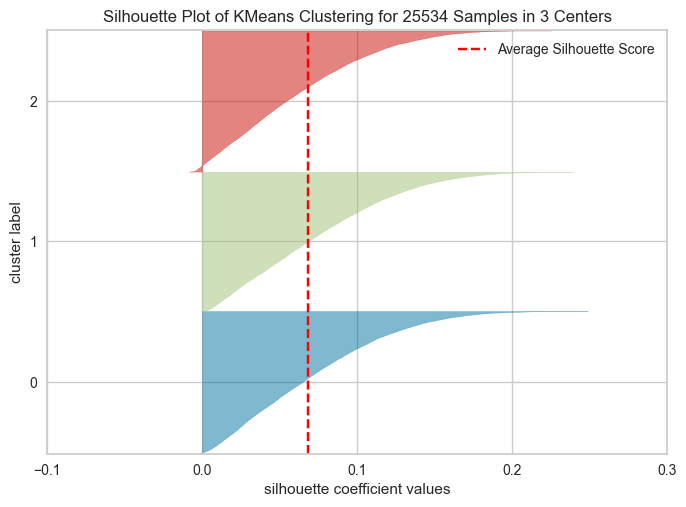



=== Silhouette plot for 4 Clusters ===


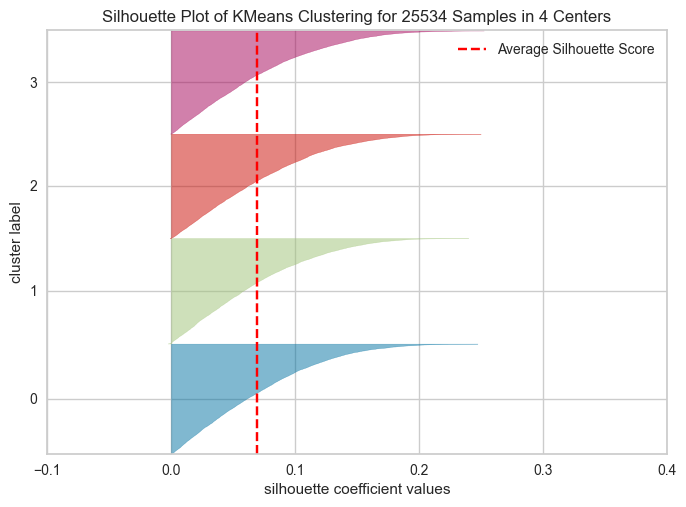



=== Silhouette plot for 5 Clusters ===


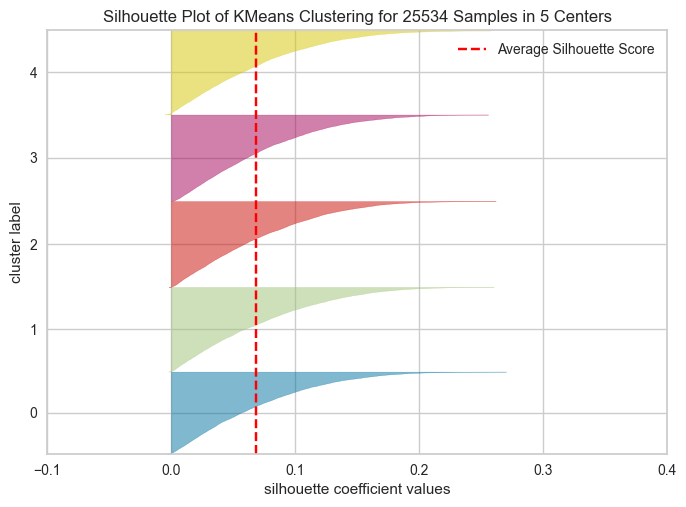

In [15]:
from yellowbrick.cluster import SilhouetteVisualizer

# 6 is not inclusive, it will stop at 5
n_cluster_start, n_cluster_stop = 2, 6

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette') # here you define silhouette
visualizer.fit(df_analysis)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters, random_state=0),
                                      colors='yellowbrick')
    visualizer.fit(df_analysis)
    visualizer.show()
    plt.show()
    print("\n")


Silhouette Elbow Plot suggests k= 3

therefore we look at the silhouette plots of 3 and 4 since the elbow method suggested 4 clusters.

Let's first look at the silhouette plot for 3 clusters. We notice that there are no clusters with
silhouette scores below the average score. 

Looking at the silhouette for 4 clusters, we also note
that there are no clusters with silhouette scores below the average score, but the average score
from 3 clusters is higher, and for this particular case, we'll use it as the deciding criteria.

As a result, we will pick 3 clusters as the optimal number.

Note, if the pipeline with 3 clusters didn't perform properly,
we could try a pipeline using 4 clusters instead.

In [19]:
def PipelineCluster():
    pipeline_base = Pipeline([
        ("DropFeatures", DropFeatures(features_to_drop=["LoanID", "Default"])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=["EmploymentType", "MaritalStatus", "LoanPurpose", 
                                                                "HasMortgage", "HasDependents", "HasCoSigner", "Education"])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman",
                                                              threshold=0.5, selection_method="variance")),

        ("scaler", StandardScaler()),

        ("PCA", PCA(n_components=9, random_state=0)),

        # we update n_clusters to 3
        ("model", KMeans(n_clusters=2, random_state=0)),


    ])
    return pipeline_base


PipelineCluster()


Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['LoanID', 'Default'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['EmploymentType', 'MaritalStatus',
                                           'LoanPurpose', 'HasMortgage',
                                           'HasDependents', 'HasCoSigner',
                                           'Education'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.5)),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=9, random_state=0)),
                ('model', KMeans(n_clusters=2, random_state=0))])

## Fit Cluster Pipeline

Quick recap of our data for training cluster pipeline

In [20]:
# full dataset is the training data since there is no target variable to make a test set and test performance on unseen data.
X = df.copy()
print(X.shape)
X.head(3)

(25534, 18)


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,QPIE1NQFSY,57,51244,180500,627,94,2,15.22,24,0.50,Master's,Full-time,Married,Yes,Yes,Auto,No,0
1,KKHO8S35ZJ,65,148892,194233,603,3,1,18.98,36,0.67,Bachelor's,Part-time,Married,No,No,Education,No,0
2,8SBBOMTDSC,61,55177,163218,422,15,4,6.38,60,0.43,Bachelor's,Full-time,Single,No,No,Home,Yes,0


Fit Cluster pipeline

In [21]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['LoanID', 'Default'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['EmploymentType', 'MaritalStatus',
                                           'LoanPurpose', 'HasMortgage',
                                           'HasDependents', 'HasCoSigner',
                                           'Education'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.5)),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=9, random_state=0)),
                ('model', KMeans(n_clusters=2, random_state=0))])

## Add cluster predictions to dataset

We add a column "`Clusters`" (with the cluster pipeline predictions) to the dataset (for subsequent analysis)

In [22]:
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(5)

(25534, 19)


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default,Clusters
0,QPIE1NQFSY,57,51244,180500,627,94,2,15.22,24,0.50,Master's,Full-time,Married,Yes,Yes,Auto,No,0,1
1,KKHO8S35ZJ,65,148892,194233,603,3,1,18.98,36,0.67,Bachelor's,Part-time,Married,No,No,Education,No,0,0
2,8SBBOMTDSC,61,55177,163218,422,15,4,6.38,60,0.43,Bachelor's,Full-time,Single,No,No,Home,Yes,0,0
3,D6SEZ70FFR,19,15956,174360,548,43,2,15.04,12,0.66,High School,Full-time,Married,No,Yes,Auto,No,1,1
4,LD4A0RWZWY,50,98077,131190,341,3,4,5.18,24,0.30,Master's,Unemployed,Married,No,Yes,Education,Yes,0,1


* Clusters frequencies 
          proportion
Clusters            
1                0.5
0                0.5 




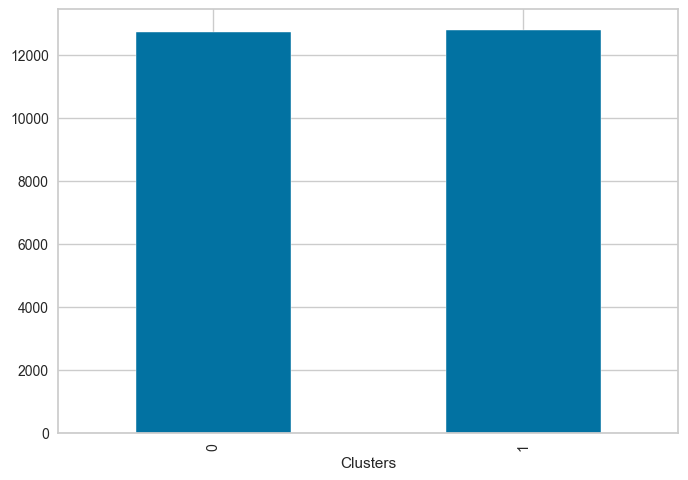

In [23]:
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

cluster 3 is dominant with almost 70 % of the data

let's visualize the PCA components and the clusters.

To simplify, we will make a 2D scatter plot and plot the first 2 most important PCA components
coloring the points by clusters. In addition, we will add the the cluster centroids,
or the middle of a cluster according to the algorithm's calculations.

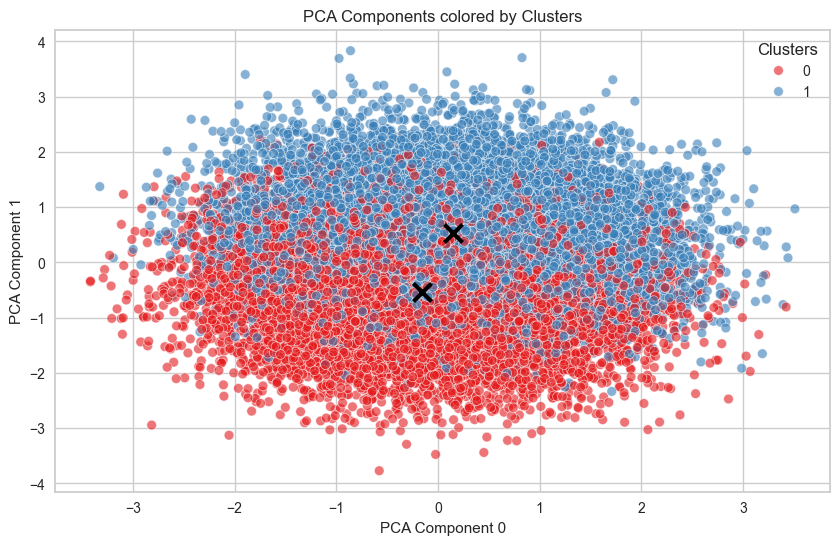

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_analysis[:, 0], y=df_analysis[:, 1],
                hue=X['Clusters'], palette='Set1', alpha=0.6)
plt.scatter(x=pipeline_cluster['model'].cluster_centers_[:, 0], y=pipeline_cluster['model'].cluster_centers_[:, 1],
            marker="x", s=169, linewidths=3, color="black")
plt.xlabel("PCA Component 0")
plt.ylabel("PCA Component 1")
plt.title("PCA Components colored by Clusters")
plt.show()


Each data point is a user and belongs to a given cluster. As we have studied, the PCA components
combine the original features, so we don't have a clear interpretation for the component. Instead,
we plot the two main components after applying PCA and visualising how the algorithm clustered it.

As you can see, in general, the data points look to be separable, there are a few regions where the
data points from different clusters are cluttered, but that is in the minority of the plot.

We save the cluster predictions from this pipeline to use in the future. We will get back to that in a later stage.

In [27]:
cluster_predictions_with_all_variables = X['Clusters']
cluster_predictions_with_all_variables

0       1
1       2
2       2
3       1
4       2
       ..
7038    2
7039    2
7040    1
7041    2
7042    2
Name: Clusters, Length: 7043, dtype: int32

At this point, we've clustered the data but haven't found a meaning for each cluster yet.

So next, we will fit a classifier pipeline where Clusters will be the target,
and the remaining variables will be features. The reason for using a classifier is that we
can assume that the most relevant features will be the most relevant variables that define a cluster.

## Fit a classifier, where the target is cluster predictions and features remaining variables

We copy `X` to a DataFrame `df_clf`

In [25]:
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

(25534, 19)


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default,Clusters
0,QPIE1NQFSY,57,51244,180500,627,94,2,15.22,24,0.50,Master's,Full-time,Married,Yes,Yes,Auto,No,0,1
1,KKHO8S35ZJ,65,148892,194233,603,3,1,18.98,36,0.67,Bachelor's,Part-time,Married,No,No,Education,No,0,0
2,8SBBOMTDSC,61,55177,163218,422,15,4,6.38,60,0.43,Bachelor's,Full-time,Single,No,No,Home,Yes,0,0


Split Train and Test sets

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['Clusters'], axis=1),
    df_clf['Clusters'],
    test_size=0.2,
    random_state=0
)

print(X_train.shape, X_test.shape)


(20427, 18) (5107, 18)


Create classifier pipeline steps

In [28]:
# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithm
from sklearn.ensemble import GradientBoostingClassifier


def PipelineClf2ExplainClusters():
    pipeline_base = Pipeline([
        ("DropFeatures", DropFeatures(features_to_drop=["LoanID", "Default"])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=["EmploymentType", "MaritalStatus", "LoanPurpose", 
                                                                "HasMortgage", "HasDependents", "HasCoSigner", "Education"])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman",
                                                              threshold=0.5, selection_method="variance")),

        ("scaler", StandardScaler()),

        ("feat_selection", SelectFromModel(
            GradientBoostingClassifier(random_state=0))),

        #  use an algorithm that typically offers good results, and feature importance
        # can be assessed with .features_importance_
        ("model", GradientBoostingClassifier(random_state=0)),

    ])
    return pipeline_base


PipelineClf2ExplainClusters()


Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['LoanID', 'Default'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['EmploymentType', 'MaritalStatus',
                                           'LoanPurpose', 'HasMortgage',
                                           'HasDependents', 'HasCoSigner',
                                           'Education'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.5)),
                ('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingClassifier(random_state=0))),
                ('model', GradientBoostingClassifier(random_state=0))])

Fit the classifier to the training data

In [29]:
pipeline_clf_cluster = PipelineClf2ExplainClusters()
pipeline_clf_cluster.fit(X_train, y_train)

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['LoanID', 'Default'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['EmploymentType', 'MaritalStatus',
                                           'LoanPurpose', 'HasMortgage',
                                           'HasDependents', 'HasCoSigner',
                                           'Education'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.5)),
                ('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingClassifier(random_state=0))),
                ('model', GradientBoostingClassifier(random_state=0))])

## Evaluate classifier performance on Train and Test Sets

You may have noticed
that the target is imbalanced, because as we saw in a previous bar plot cluster 1 is dominant.

So first, we will fit the model without handling the target imbalance and we will check if the
performance is good. If it is, we can move on. If not, then we would need to go back to this step
to address this target imbalance. 

However, when using a classifier to predict cluster predictions,
the expectation is that we would not have any issues due to target imbalance.
The clustering algorithm should be able to make its predictions
using its own internal logic, and a classifier algorithm can be used to map the relationships.

At this stage of the workflow, we could also conduct a detailed hyperparameter
optimization to find the best model. However, we are only interested in finding a pipeline
that can explain the relationship between the target - Clusters - and the features to assess
the feature importance afterwards. As a result, we will omit this step from the workflow here.

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89     10210
           1       0.89      0.89      0.89     10217

    accuracy                           0.89     20427
   macro avg       0.89      0.89      0.89     20427
weighted avg       0.89      0.89      0.89     20427



In [31]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2513
           1       0.89      0.89      0.89      2594

    accuracy                           0.88      5107
   macro avg       0.88      0.88      0.88      5107
weighted avg       0.88      0.88      0.88      5107



classification report for both train and test sets,
the classifier has a good performance.

## Assess the most important Features that define a cluster

* These are the 1 most important features in descending order. The model was trained on them: 
['HasDependents'] 



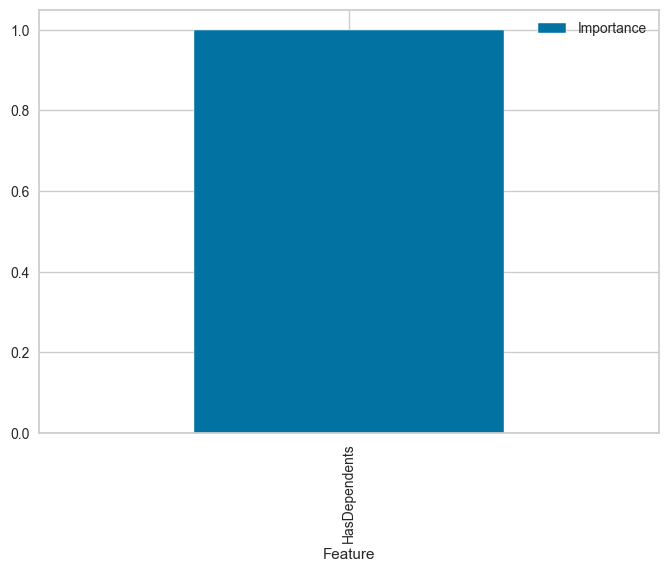

In [32]:
# after data cleaning and feature engineering, the feature space changes

# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 3
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf_cluster.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[pipeline_clf_cluster['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf_cluster['feat_selection'].get_support()],
    'Importance': pipeline_clf_cluster['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# reassign best features in importance order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features} \n")
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


We will store the best_features to use at a later stage.

In [33]:
best_features_pipeline_all_variables = best_features
best_features_pipeline_all_variables

['HasDependents']

Online Backup, MonthlyCharges
and Phone Service are the variables that most help to define the clusters.
We can now use these variables to explain each cluster's profile.

## Cluster Analysis

Load function that plots a table with description for all Clusters

The first function outputs a table showing each cluster's most common values for a given feature;
and needs a DataFrame with the most important features and cluster predictions.

In [34]:

def DescriptionAllClusters(df, decimal_points=3):

    DescriptionAllClusters = pd.DataFrame(
        columns=df.drop(['Clusters'], axis=1).columns)
    # iterate on each cluster , calls Clusters_IndividualDescription()
    for cluster in df.sort_values(by='Clusters')['Clusters'].unique():

        EDA_ClusterSubset = df.query(
            f"Clusters == {cluster}").drop(['Clusters'], axis=1)
        ClusterDescription = Clusters_IndividualDescription(
            EDA_ClusterSubset, cluster, decimal_points)
        DescriptionAllClusters = pd.concat(
            [ClusterDescription, DescriptionAllClusters])

    DescriptionAllClusters.set_index(['Cluster'], inplace=True)
    return DescriptionAllClusters


def Clusters_IndividualDescription(EDA_Cluster, cluster, decimal_points):

    ClustersDescription = pd.DataFrame(columns=EDA_Cluster.columns)
    # for a given cluster, iterate over all columns
    # if the variable is numerical, calculate the IQR: display as Q1 -- Q3.
    # That will show the range for the most common values for the numerical variable
    # if the variable is categorical, count the frequencies and displays the top 3 most frequent
    # That will show the most common levels for the category

    for col in EDA_Cluster.columns:

        try:  # eventually a given cluster will have only missing data for a given variable

            if EDA_Cluster[col].dtypes == 'object':

                top_frequencies = EDA_Cluster.dropna(
                    subset=[col])[[col]].value_counts(normalize=True).nlargest(n=3)
                Description = ''

                for x in range(len(top_frequencies)):
                    freq = top_frequencies.iloc[x]
                    category = top_frequencies.index[x][0]
                    CategoryPercentage = int(round(freq*100, 0))
                    statement = f"'{category}': {CategoryPercentage}% , "
                    Description = Description + statement

                ClustersDescription.at[0, col] = Description[:-2]

            elif EDA_Cluster[col].dtypes in ['float', 'int']:
                DescStats = EDA_Cluster.dropna(subset=[col])[[col]].describe()
                Q1 = round(DescStats.iloc[4, 0], decimal_points)
                Q3 = round(DescStats.iloc[6, 0], decimal_points)
                Description = f"{Q1} -- {Q3}"
                ClustersDescription.at[0, col] = Description

        except Exception as e:
            ClustersDescription.at[0, col] = 'Not available'
            print(
                f"** Error Exception: {e} - cluster {cluster}, variable {col}")

    ClustersDescription['Cluster'] = str(cluster)

    return ClustersDescription


Load a custom function to plot cluster distribution per Variable (absolute and relative levels)

The second function outputs the Clusters distribution across Churn levels and the Relative
Percentage Churn in each cluster. It needs a DataFrame with the clusters and churn levels.

In [35]:
import plotly.express as px


def cluster_distribution_per_variable(df, target):
    """
    The data should have 2 variables, the cluster predictions and
    the variable you want to analyze with, in this case we call "target".
    We use plotly express to create 2 plots:
    Cluster distribution across the target.
    Relative presence of the target level in each cluster.
    """
    df_bar_plot = df.groupby(['Clusters', target]).size().reset_index(name='Count')
    df_bar_plot.columns = ['Clusters', target, 'Count']
    df_bar_plot[target] = df_bar_plot[target].astype('object')

    print(f"Clusters distribution across {target} levels")
    fig = px.bar(df_bar_plot, x='Clusters', y='Count',
                 color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array',
                      tickvals=df['Clusters'].unique()))
    fig.show(renderer='jupyterlab')

    df_relative = (df
                   .groupby(["Clusters", target])
                   .size()
                   .unstack(fill_value=0)
                   .apply(lambda x: 100 * x / x.sum(), axis=1)
                   .stack()
                   .reset_index(name='Relative Percentage (%)')
                   .sort_values(by=['Clusters', target])
                   )

    print(f"Relative Percentage (%) of {target} in each cluster")
    fig = px.line(df_relative, x='Clusters', y='Relative Percentage (%)',
                  color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array',
                      tickvals=df['Clusters'].unique()))
    fig.update_traces(mode='markers+lines')
    fig.show(renderer='jupyterlab')



Create a DataFrame that contains best features and Clusters Predictions since we want to analyse the patterns for each cluster.


In [36]:
df_cluster_profile = df_clf.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)
print(df_cluster_profile.shape)
df_cluster_profile.head(3)

(25534, 2)


,HasDependents,Clusters
0,Yes,1
1,No,0
2,No,0


We want also to analyse Churn levels.

In [37]:
df_churn = pd.read_csv("outputs/datasets/collection/LoanDefaultData.csv").filter(['Default'])
# Churn is encoded as an integer,
# even being a categorical variable. Therefore for this analysis we'll change its data type to 'object'.
# for cluster analysis plot (!)
df_churn['Default'] = df_churn['Default'].astype('object')
df_churn.head(3)

,Default
0,0
1,0
2,0


### Cluster profile based on the best features

In [38]:
pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df=pd.concat([df_cluster_profile,df_churn], axis=1), decimal_points=0)
clusters_profile

,HasDependents,Default
Cluster,,
1,"'Yes': 89% , 'No': 11%","'0': 90% , '1': 10%"
0,"'No': 88% , 'Yes': 12%","'0': 87% , '1': 13%"


Cluster Description using the feature importance order:
* Cluster 0 has users without Internet, who are low spenders and have a phone
* Cluster 2 has users with Internet, who are high spenders with a phone.
* Cluster 1 has users with Internet, who are mid-range spenders but without a phone.

### Clusters distribution across Churn levels & Relative Percentage of Churn in each cluster

In [40]:
# We parse a DataFrame that contains Clusters and Churn levels. Both variables
# are categorical to visualize the distribution of Cluster in a bar plot and color by Churn level.
df_cluster_vs_churn=  df_churn.copy()
df_cluster_vs_churn['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_churn, target='Default')

Clusters distribution across Default levels


Relative Percentage (%) of Default in each cluster


Business Interpretation:

In summary then, we can notice that historically, users in Cluster 0 don't tend to Churn,
whereas in Cluster 1 a third of users churned and in Cluster 2 a quarter of users churned.

From the Predict Churn study, we noticed that the contract type and InternetService are the
predictors' variables to determine if a person will churn or not. 

One potential
action when you detect that a given prospect is expected to churn and they belong to cluster 1 or 2
is to mainly avoid month to month contract, as we learned in the churned customer study.


# Fit New Cluster Pipeline with most important features

In order to reduce feature space, we will study the trade-off between the previous Cluster Pipeline (fitted with all variables) and Pipeline using the variables that are most important to define the clusters from the previous pipeline

In [41]:
best_features_pipeline_all_variables

['HasDependents']

## Define trade-off and metrics to compare new and previous Cluster Pipeline

To evaluate this trade-off we will
1. Conduct a elbow method and silhouette analysis and check if the same number of clusters is suggested
2. Fit new cluster pipeline and compare if the predictions from this pipeline are "equivalent" to the predictions from the previous pipeline
3. Fit a classifier to explain cluster, and check if performance on Train and Test sets is similar to the previous pipeline
4. Check if the most important features for the classifier are the same from the previous pipeline
5. Compare if the cluster profile from both pipelines are "equivalent"

If we are happy to say **yes** for them, we can use a cluster pipeline using the features that best define the clusters from previous pipeline!
* The **gain** is that in real-time (which is the major purpose of Machine Learning) you will need fewer variables for predicting clusters for your prospects.

However, if your new pipeline doesn’t meet all the requirements above, you need to discuss with the
stakeholders if they are fine with the conditions and interpretations from this new pipeline.
Once again, in this case, typically, there is no right or wrong; it is more of a contextual
decision whether or not the stakeholders will be happy with the model output and interpretation.

## Subset data with the most relevant variables

In [42]:
df_reduced = df.filter(best_features_pipeline_all_variables)
df_reduced.head(3)

,HasDependents
0,Yes
1,No
2,No


## Rewrite Cluster Pipeline

In [46]:
def PipelineCluster():
    pipeline_base = Pipeline([

        # we update the pipeline, considering only the most important variables from the previous pipeline
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=["HasDependents"])),
        # it doesn't need SmartCorrelation

        ("scaler", StandardScaler()),

        # No PCA step needed, since we know which features to consider

        ("model", KMeans(n_clusters=3, random_state=0)),


    ])
    return pipeline_base


PipelineCluster()


Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['HasDependents'])),
                ('scaler', StandardScaler()),
                ('model', KMeans(n_clusters=3, random_state=0))])

## Apply Elbow Method and Silhouette analysis

In [47]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df_reduced)

print(df_analysis.shape,'\n', type(df_analysis))

(25534, 1) 
 <class 'numpy.ndarray'>


Elbow Analysis

c:\Users\kathr\Nextcloud\Dokumente\Karriere\Projekte\vscode-projects\PP5\LoanGuard\.venv\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.

c:\Users\kathr\Nextcloud\Dokumente\Karriere\Projekte\vscode-projects\PP5\LoanGuard\.venv\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.

c:\Users\kathr\Nextcloud\Dokumente\Karriere\Projekte\vscode-projects\PP5\LoanGuard\.venv\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.

c:\Users\kathr\Nextcloud\Dokumente\Karriere\Projekte\vscode-projects\PP5\LoanGuard\.venv\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (6). Possibly due

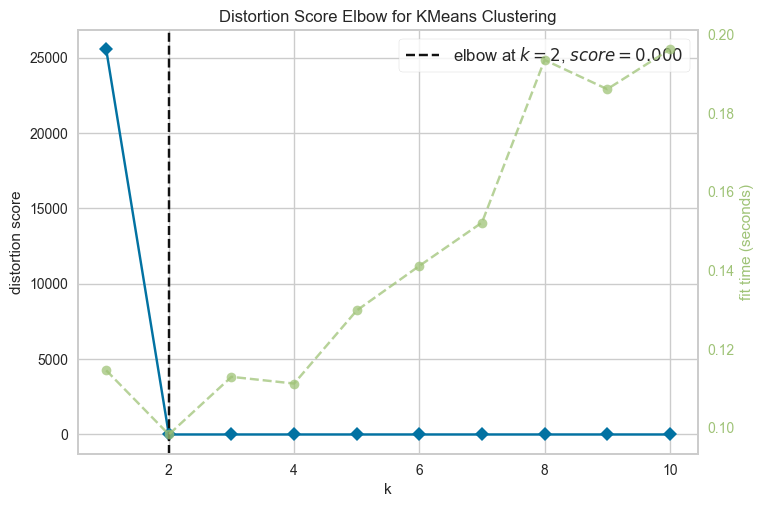

In [48]:
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,11))
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()

 We note that this plot suggests 4 clusters
and that a sharp fall happens between 2 and 4, so we can pick this range for Silhouette analysis.

=== Average Silhouette Score for different number of clusters ===


c:\Users\kathr\Nextcloud\Dokumente\Karriere\Projekte\vscode-projects\PP5\LoanGuard\.venv\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.

c:\Users\kathr\Nextcloud\Dokumente\Karriere\Projekte\vscode-projects\PP5\LoanGuard\.venv\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.

c:\Users\kathr\Nextcloud\Dokumente\Karriere\Projekte\vscode-projects\PP5\LoanGuard\.venv\Lib\site-packages\yellowbrick\utils\kneed.py:171: RuntimeWarning:

invalid value encountered in divide

c:\Users\kathr\Nextcloud\Dokumente\Karriere\Projekte\vscode-projects\PP5\LoanGuard\.venv\Lib\site-packages\yellowbrick\utils\kneed.py:197: YellowbrickWarning:

No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.

c:\Users\kathr\Nextclo

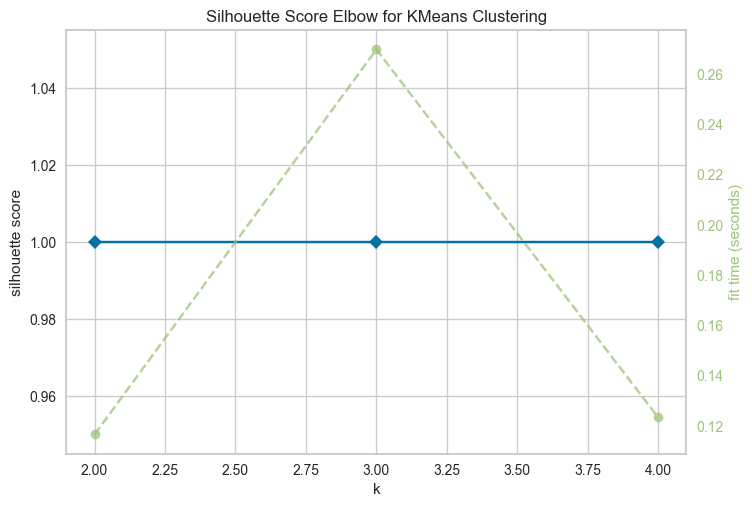



=== Silhouette plot for 2 Clusters ===


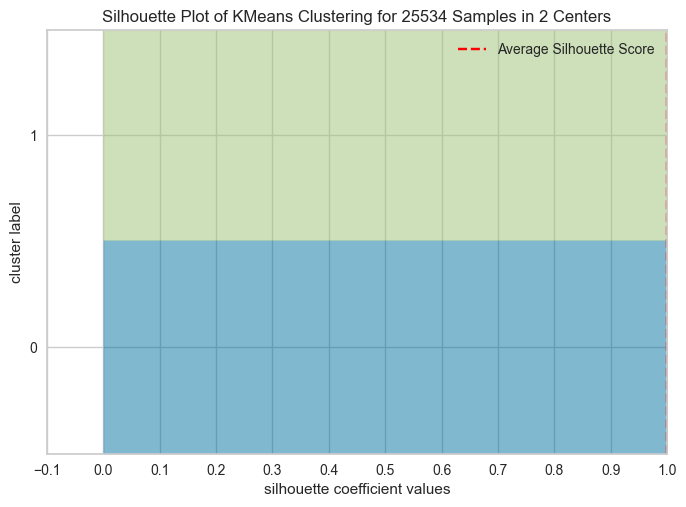



=== Silhouette plot for 3 Clusters ===


c:\Users\kathr\Nextcloud\Dokumente\Karriere\Projekte\vscode-projects\PP5\LoanGuard\.venv\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.



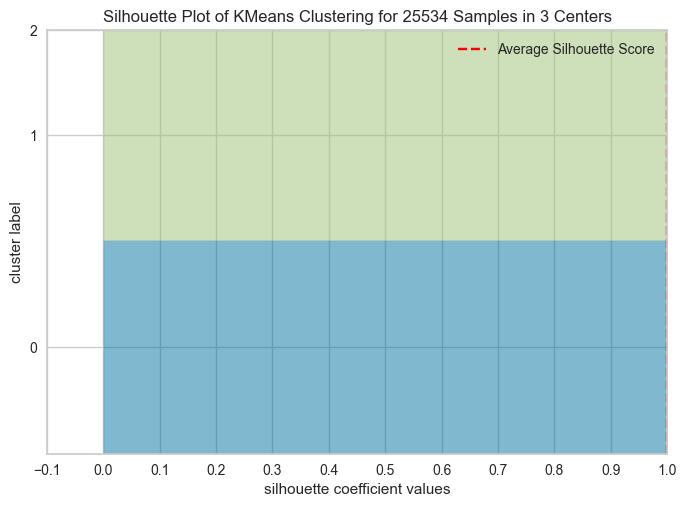



=== Silhouette plot for 4 Clusters ===


c:\Users\kathr\Nextcloud\Dokumente\Karriere\Projekte\vscode-projects\PP5\LoanGuard\.venv\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.



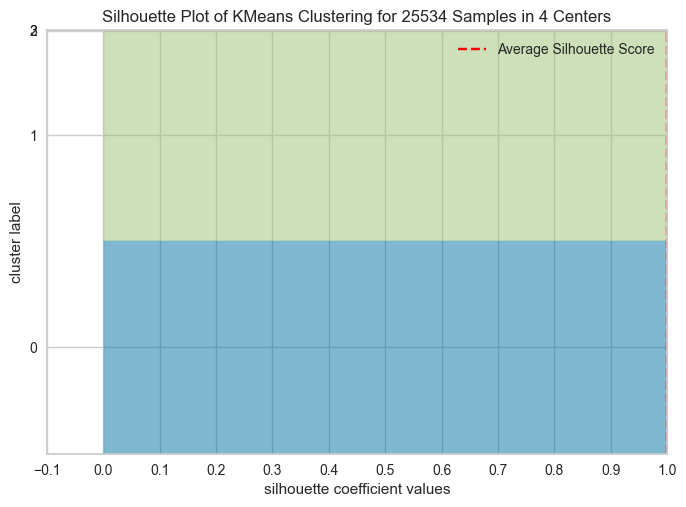

In [49]:
from yellowbrick.cluster import SilhouetteVisualizer

n_cluster_start, n_cluster_stop = 2, 5

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters, random_state=0),
                                      colors='yellowbrick')
    visualizer.fit(df_analysis)
    visualizer.show()
    plt.show()
    print("\n")


Note that in the average silhouette score plot,
clusters 3 and 4 produce a 0.68 score, so both choices would work based on this plot.

We then check the silhouette plot for 3 and 4 clusters.
We don’t see much difference between them; both have clusters with silhouette scores
that surpass the average, they also don’t have negative silhouette values.

As well as this, the number of values above the average score in both cases look to be similar.
Therefore, we’ll select 3 clusters as optimal. If the upcoming analysis fails, we will revisit the
pipeline and update the number of clusters to 4.

## Fit New Cluster Pipeline

We set X as our training set for the cluster. It is a copy of df_reduced

In [52]:
X = df_reduced.copy()
print(X.shape)
X.head(3)

(7043, 3)


,OnlineBackup,MonthlyCharges,PhoneService
0,Yes,29.85,No
1,No,56.95,Yes
2,Yes,53.85,Yes


Fit Cluster pipeline

In [53]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['OnlineBackup', 'PhoneService'])),
                ('scaler', StandardScaler()),
                ('model', KMeans(n_clusters=3, random_state=0))])

## Add cluster predictions to dataset

We add a column "`Clusters`" (with the cluster pipeline predictions) to the dataset

In [54]:
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(3)

(7043, 4)


,OnlineBackup,MonthlyCharges,PhoneService,Clusters
0,Yes,29.85,No,2
1,No,56.95,Yes,1
2,Yes,53.85,Yes,1


* Clusters frequencies 
          proportion
Clusters            
1               0.69
0               0.22
2               0.10 




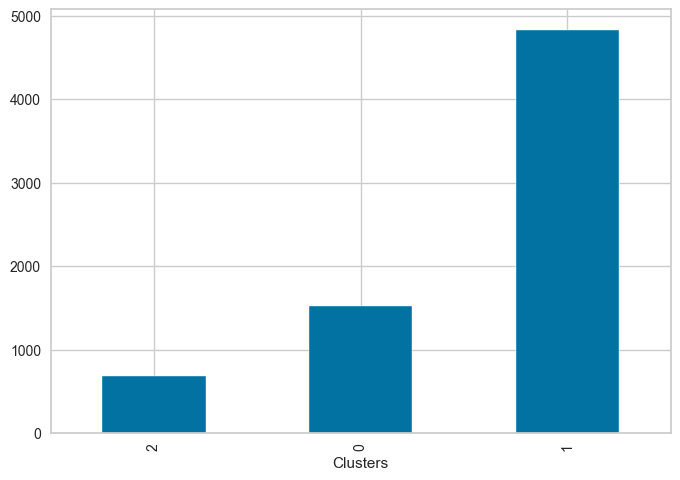

In [55]:
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

The result is pretty similar to the previous pipeline.

So that's fine, but how similar are the predictions from this cluster
and the previous cluster?

## Compare current cluster predictions to previous cluster predictions

We just fitted a new cluster pipeline and want to compare if its predictions are "equivalent" to the previous cluster.

These are the predictions from the **previous** cluster pipeline - trained with all variables 

In [56]:
cluster_predictions_with_all_variables

0       1
1       2
2       2
3       1
4       2
       ..
7038    2
7039    2
7040    1
7041    2
7042    2
Name: Clusters, Length: 7043, dtype: int32

And these are the predictions from **current** cluster pipeline (trained with `['OnlineBackup', 'MonthlyCharges', 'PhoneService']`)

In [57]:
cluster_predictions_with_best_features = X['Clusters'] 
cluster_predictions_with_best_features

0       2
1       1
2       1
3       2
4       1
       ..
7038    1
7039    1
7040    2
7041    1
7042    1
Name: Clusters, Length: 7043, dtype: int32

We use a confusion matrix to evaluate if the predictions of both pipelines are **"equivalent"**

In [60]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(cluster_predictions_with_all_variables, cluster_predictions_with_best_features))

[[1526   41    0]
 [   0    0  682]
 [   0 4794    0]]


We will use a confusion matrix to assess if the prediction from one
pipeline is “equivalent” to the other pipeline.
So, let’s begin by describing the similarities. We note here that a group that was clustered as
“Cluster 1” in the previous pipeline was also clustered as “Cluster 1” in the new pipeline.
And we note the same behaviour for “Cluster 2”.
For differences, we can see that for the first Cluster, we have the following dynamic:
1526 data points were listed as “Cluster 0” in the previous and new pipeline,
but 31 data points were labelled as “Cluster 0” previously but are now as “Cluster 1”.
You may ask yourself, is that bad?
The answer is no since for the comparison, only a minority of the data points are not “equivalent”.
As a result, we say that the predictions from both pipelines are in-fact, “equivalent.”
When we reach this equivalence, it means both pipelines have "clustered" in a similar fashion.

## Fit a classifier, where the target is cluster predictions and features remaining variables

We are again in a position where we can fit a cluster pipeline but we will first need
clarification on the most relevant features for the clusters. We will use a classifier
pipeline to help in this task using the supervised learning workflow that we're already familiar with.

In [61]:
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

(7043, 4)


,OnlineBackup,MonthlyCharges,PhoneService,Clusters
0,Yes,29.85,No,2
1,No,56.95,Yes,1
2,Yes,53.85,Yes,1


Split Train and Test sets

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['Clusters'], axis=1),
    df_clf['Clusters'],
    test_size=0.2,
    random_state=0
)

print(X_train.shape, X_test.shape)


(5634, 3) (1409, 3)


Rewrite pipeline to explain clusters

In [63]:
def PipelineClf2ExplainClusters():
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['OnlineBackup', 'PhoneService'])),

        # it doesn't need SmartCorrelation

        ("scaler", StandardScaler()),

        # we don't consider feature selection step, since we know which features to consider

        ("model", GradientBoostingClassifier(random_state=0)),

    ])
    return pipeline_base


PipelineClf2ExplainClusters()


Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['OnlineBackup', 'PhoneService'])),
                ('scaler', StandardScaler()),
                ('model', GradientBoostingClassifier(random_state=0))])

## Fit a classifier, where the target is cluster labels and features remaining variables

Create and fit a classifier pipeline to learn the feature importance when defining a cluster

In [64]:
pipeline_clf_cluster = PipelineClf2ExplainClusters()
pipeline_clf_cluster.fit(X_train,y_train)

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['OnlineBackup', 'PhoneService'])),
                ('scaler', StandardScaler()),
                ('model', GradientBoostingClassifier(random_state=0))])

## Evaluate classifier performance on Train and Test Sets

In [65]:
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1222
           1       1.00      1.00      1.00      3870
           2       1.00      1.00      1.00       542

    accuracy                           1.00      5634
   macro avg       1.00      1.00      1.00      5634
weighted avg       1.00      1.00      1.00      5634



In [66]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       304
           1       1.00      1.00      1.00       965
           2       1.00      1.00      1.00       140

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409



## Assess Most Important Features

* These are the 3 most important features in descending order. The model was trained on them: 
['OnlineBackup', 'MonthlyCharges', 'PhoneService']


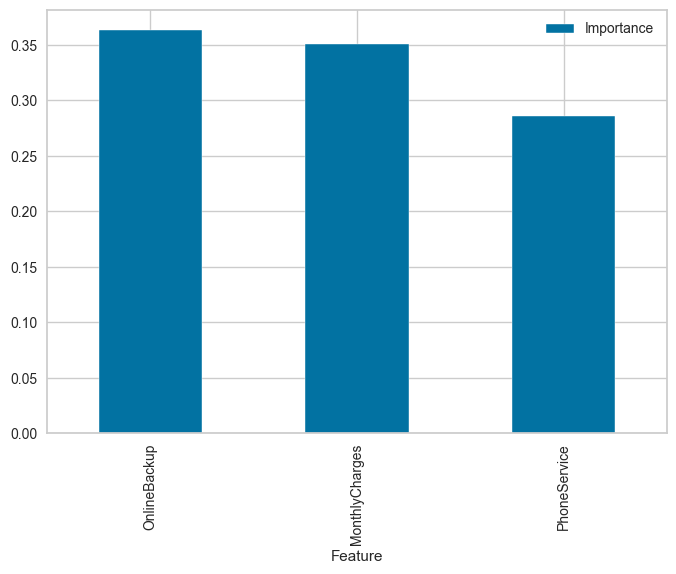

In [67]:
# since we don't have feature selection step in this pipeline, best_features is Xtrain columns
best_features = X_train.columns.to_list()

# create a DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_clf_cluster['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


When assessing the feature importance, it is worth noting that in this pipeline we don’t have the
feature selection step, so the best_features for this code are the training set columns.
We also note that the feature importance plot is pretty similar to what we had in the previous section.
As a result, the best features to define a cluster from the previous pipeline
are the same for the new pipeline.

## Cluster Analysis

Create a DataFrame that contains the best features and Clusters Predictions: we want to analyse the patterns for each cluster.


In [68]:
df_cluster_profile = df_clf.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)
df_cluster_profile.head(3)

,OnlineBackup,MonthlyCharges,PhoneService,Clusters
0,Yes,29.85,No,2
1,No,56.95,Yes,1
2,Yes,53.85,Yes,1


We want also to analyse Churn levels

In [69]:
df_churn = pd.read_csv("outputs/datasets/collection/TelcoCustomerChurn.csv").filter(['Churn'])
df_churn['Churn'] = df_churn['Churn'].astype('object')
df_churn.head(3)

,Churn
0,0
1,0
2,1


### Cluster profile on most important features

In [70]:
pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df= pd.concat([df_cluster_profile,df_churn], axis=1), decimal_points=0)
clusters_profile

,OnlineBackup,MonthlyCharges,PhoneService,Churn
Cluster,,,,
2,"'No': 58% , 'Yes': 42%",34.0 -- 51.0,'No': 100%,"'0': 75% , '1': 25%"
1,"'No': 56% , 'Yes': 44%",70.0 -- 96.0,'Yes': 100%,"'0': 67% , '1': 33%"
0,'No internet service': 100%,20.0 -- 21.0,'Yes': 100%,"'0': 93% , '1': 7%"


### Clusters distribution across Churn levels & Relative Percentage of Churn in each cluster

In [71]:
df_cluster_vs_churn=  df_churn.copy()
df_cluster_vs_churn['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_churn, target='Churn')

Clusters distribution across Churn levels


Relative Percentage (%) of Churn in each cluster


there is a minor
difference in the cluster profile. However, that is not significant and overall we can achieve the
same interpretations from the previous pipeline. In relation to the cluster distribution
across churn levels, there is no change between this and the previous pipeline.

## Which pipeline should I deploy?

Let's recap the criteria we consider to evaluate the **trade-off**
1. Conduct an elbow method and silhouette analysis and check if the same number of clusters is suggested.
2. Fit a new cluster pipeline and compare if the predictions from this pipeline are "equivalent" to the predictions from the previous pipeline.
3. Fit a classifier to explain cluster and check if performance on Train and Test sets is similar to the previous pipeline.
4. Check if the most important features for the classifier are the same from the previous pipeline.
5. Compare if the cluster profile from both pipelines is "equivalent".


In [72]:
pipeline_cluster

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['OnlineBackup', 'PhoneService'])),
                ('scaler', StandardScaler()),
                ('model', KMeans(n_clusters=3, random_state=0))])

We considered 5 criteria to evaluate the tradeoff when fitting the new pipeline,
and the only criteria that didn't have a straight clear and positive answer
was criteria 1, where the elbow method and silhouette analysis indicated that
either a pipeline with 3 or 4 clusters would suit the data with 3 features.

Since the remaining criteria, especially the cluster profile,
showed equivalent results, we are selecting the cluster pipeline fitted only with 'OnlineBackup',
'MonthlyCharges' and 'PhoneService'. 

# Push files to Repo


We will generate the following files

* Cluster Pipeline
* Train Set
* Feature importance plot
* Clusters Description
* Cluster Silhouette


In [73]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/cluster_analysis/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)


## Cluster pipeline

In [74]:
pipeline_cluster

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['OnlineBackup', 'PhoneService'])),
                ('scaler', StandardScaler()),
                ('model', KMeans(n_clusters=3, random_state=0))])

In [75]:
joblib.dump(value=pipeline_cluster, filename=f"{file_path}/cluster_pipeline.pkl")

['outputs/ml_pipeline/cluster_analysis/v1/cluster_pipeline.pkl']

## Train Set

In [76]:
print(df_reduced.shape)
df_reduced.head(3)

(7043, 3)


,OnlineBackup,MonthlyCharges,PhoneService
0,Yes,29.85,No
1,No,56.95,Yes
2,Yes,53.85,Yes


In [77]:
df_reduced.to_csv(f"{file_path}/TrainSet.csv", index=False)

## Most important features plot

These are the features that define a cluster

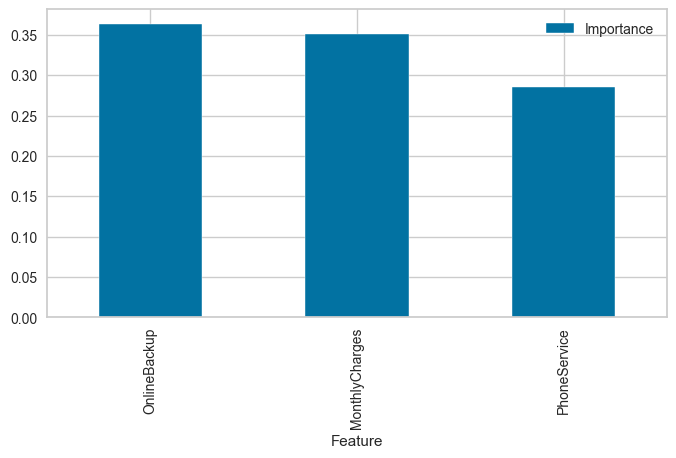

In [78]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance', figsize=(8,4))
plt.show()

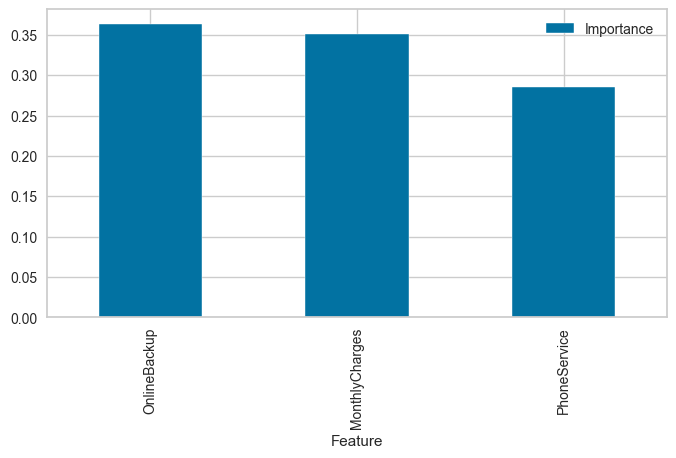

In [79]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance', figsize=(8,4))
plt.savefig(f"{file_path}/features_define_cluster.png", bbox_inches='tight', dpi=150)

## Cluster Profile

In [80]:
clusters_profile

,OnlineBackup,MonthlyCharges,PhoneService,Churn
Cluster,,,,
2,"'No': 58% , 'Yes': 42%",34.0 -- 51.0,'No': 100%,"'0': 75% , '1': 25%"
1,"'No': 56% , 'Yes': 44%",70.0 -- 96.0,'Yes': 100%,"'0': 67% , '1': 33%"
0,'No internet service': 100%,20.0 -- 21.0,'Yes': 100%,"'0': 93% , '1': 7%"


In [81]:
clusters_profile.to_csv(f"{file_path}/clusters_profile.csv")

## Cluster silhouette plot

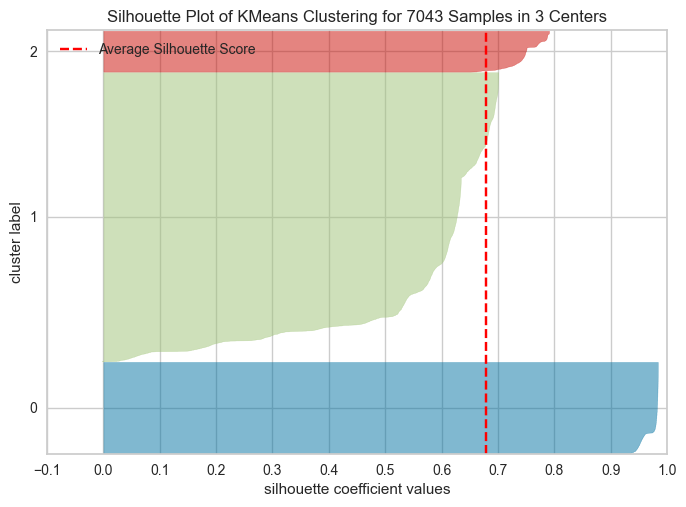

In [82]:
visualizer = SilhouetteVisualizer(Pipeline(pipeline_cluster.steps[-1:])[0] , colors='yellowbrick')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()

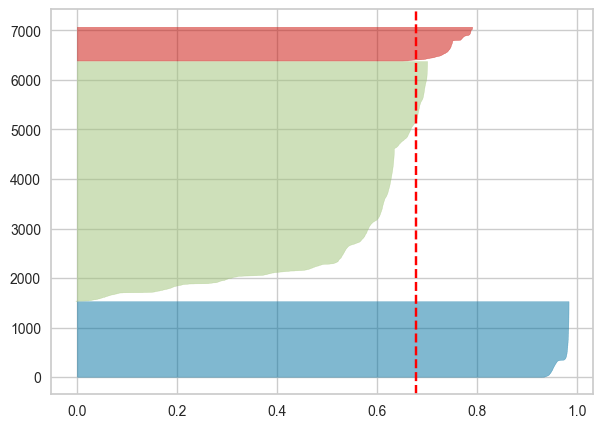

In [83]:
fig, axes = plt.subplots(figsize=(7,5))
fig = SilhouetteVisualizer(Pipeline(pipeline_cluster.steps[-1:])[0] , colors='yellowbrick', ax=axes)
fig.fit(df_analysis)

plt.savefig(f"{file_path}/clusters_silhouette.png", bbox_inches='tight',dpi=150)

Good job, clear the cell outputs, run git commands to add, commit and push files to the repo. Next, we will move on to create our dashboard!